In [1]:
from main import Task, train, test

In [2]:
task = Task()
samples, labels = task.next_batch()

In [3]:
# (batchsize, max_len, vocab_size + 1)
samples.shape

(100, 10, 4)

In [4]:
samples[0]

array([[0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.]])

In [5]:
# (batchsize, vocab_size, max_len + 1)
labels.shape

(100, 3, 11)

In [6]:
labels[0]

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]])

----

In [7]:
train(print_every=250)

Iteration 250 - Loss 0.5967335104942322
Iteration 500 - Loss 0.22820772230625153
Iteration 750 - Loss 0.1344871073961258
Iteration 1000 - Loss 0.11950059235095978
Iteration 1250 - Loss 0.11904849857091904
Iteration 1500 - Loss 0.08935666084289551
Iteration 1750 - Loss 0.08564305305480957
Iteration 2000 - Loss 0.06383078545331955
Iteration 2000 - Loss 0.06383078545331955
Training complete!


----


Input: 
[[['A']
  ['B']
  ['A']
  [' ']
  ['C']
  ['A']
  ['A']
  ['C']
  ['C']
  ['B']]]

Prediction: 
[[4 2 3]]

Encoder-Decoder Attention: 
Output step 0 attended mainly to Input steps: [0 2 5 6]
[0.175, 0.044, 0.175, 0.074, 0.046, 0.175, 0.175, 0.046, 0.046, 0.044]
Output step 1 attended mainly to Input steps: [1 9]
[0.067, 0.228, 0.067, 0.095, 0.061, 0.067, 0.067, 0.061, 0.061, 0.228]
Output step 2 attended mainly to Input steps: [4 7 8]
[0.055, 0.048, 0.055, 0.084, 0.2, 0.055, 0.055, 0.2, 0.2, 0.048]


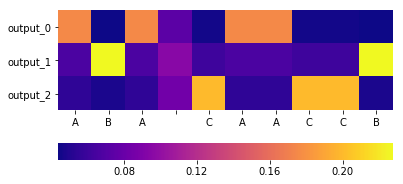

In [8]:
test()